<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/R/TextAnalysis_wR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with R [Part 2]

**Discription:**
- Prepare dataset for training
- Build Model
  - RNN for Text Classification
  - RandomForest
- Visualizing model performance

In [ ]:
packages <- c("tidymodel", "dplyr", "scales", "ggplot2", "RColorBrewer", "ggpubr", "patchwork", 
              "reshape2", "tidyr", "yardstick")
install.packages(packages, quiet = TRUE)
lapply(packages, require, character.only = TRUE)

In [95]:
discreate_palette <- "virdis"
sequential_palette <- "Blues"
diverging_palette <- "Spectral"
getPalette <- colorRampPalette(brewer.pal(8, "Spectral"))

options(repr.plot.width = 11, repr.plot.height = 8)
theme_set(theme_minimal(base_size = 10))
theme_update(plot.title = element_text(size = 18, face = "bold"), plot.subtitle = element_text(size = 15, face = "italic"), 
          plot.caption = element_text(size = 12))

#### Read in **word_vectors** csv.file

In [10]:
dataset <- read.csv("/word_vectors.csv", header = TRUE)

In [11]:
head(dataset, 3)

,word,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V24,V25,V26,V27,V28,V29,V30,part,sentiment,pos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,abomination,0.7143283,-0.002424412,-0.45409349,-0.3946332,0.1393975,-0.5302257,-0.1981578,-0.3678781,0.08688117,⋯,0.01899761,0.4880553,0.22197923,0.49783079,-0.3385483,-0.24637231,0.14752459,2,negative,Noun
2,abound,-0.2218433,0.205743494,-0.74835696,0.5552839,-0.6325334,-0.1254800,-0.3712725,-0.8263387,0.72384927,⋯,-0.75694425,-0.4813911,0.47475638,0.70216948,-0.6755939,0.04069773,0.07322151,2,positive,Verb (intransitive)
3,absentee,-0.5265498,0.352335773,0.02974225,0.1187421,0.4449063,0.7710985,0.5169099,-0.1676848,-0.40571727,⋯,-0.44593418,0.6640152,-0.01083494,-0.06695252,-0.6996671,0.61839038,-0.38138210,2,negative,Noun


`summarise()` has grouped output by 'part'. You can override using the `.groups` argument.



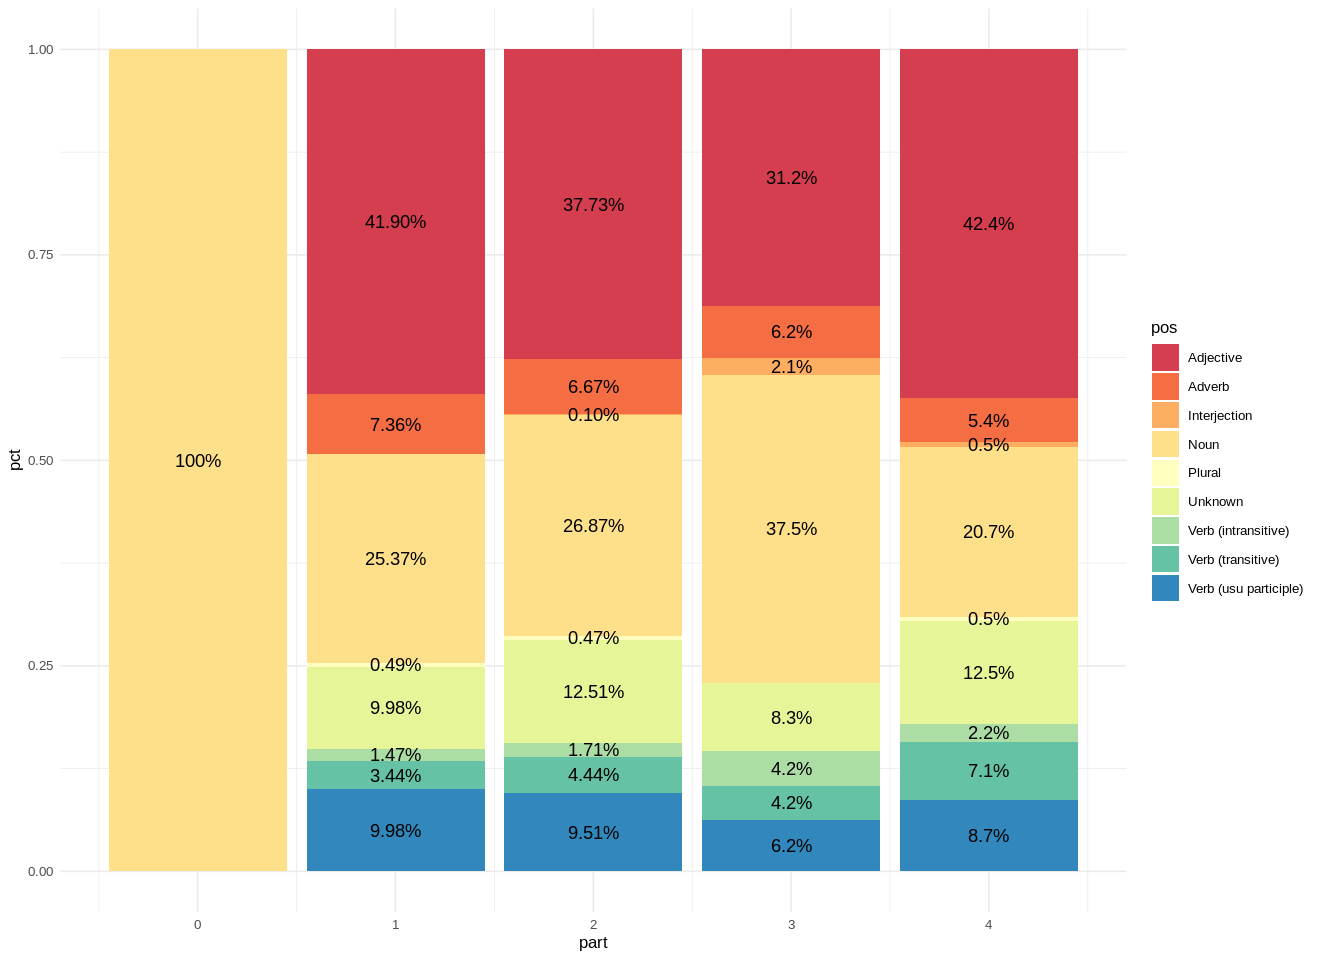

In [12]:
dataset %>% 
  group_by(part, pos) %>%
  summarise(n = n()) %>%
  mutate(pct = n / sum(n), label = percent(pct)) %>%
  ggplot(aes(part, pct, fill = pos, label = label)) +
    geom_bar(position = "fill", stat = "identity") +
    geom_text(, position = position_stack(vjust = 0.5), check_overlap = T) +
    scale_fill_brewer(palette = "Spectral")

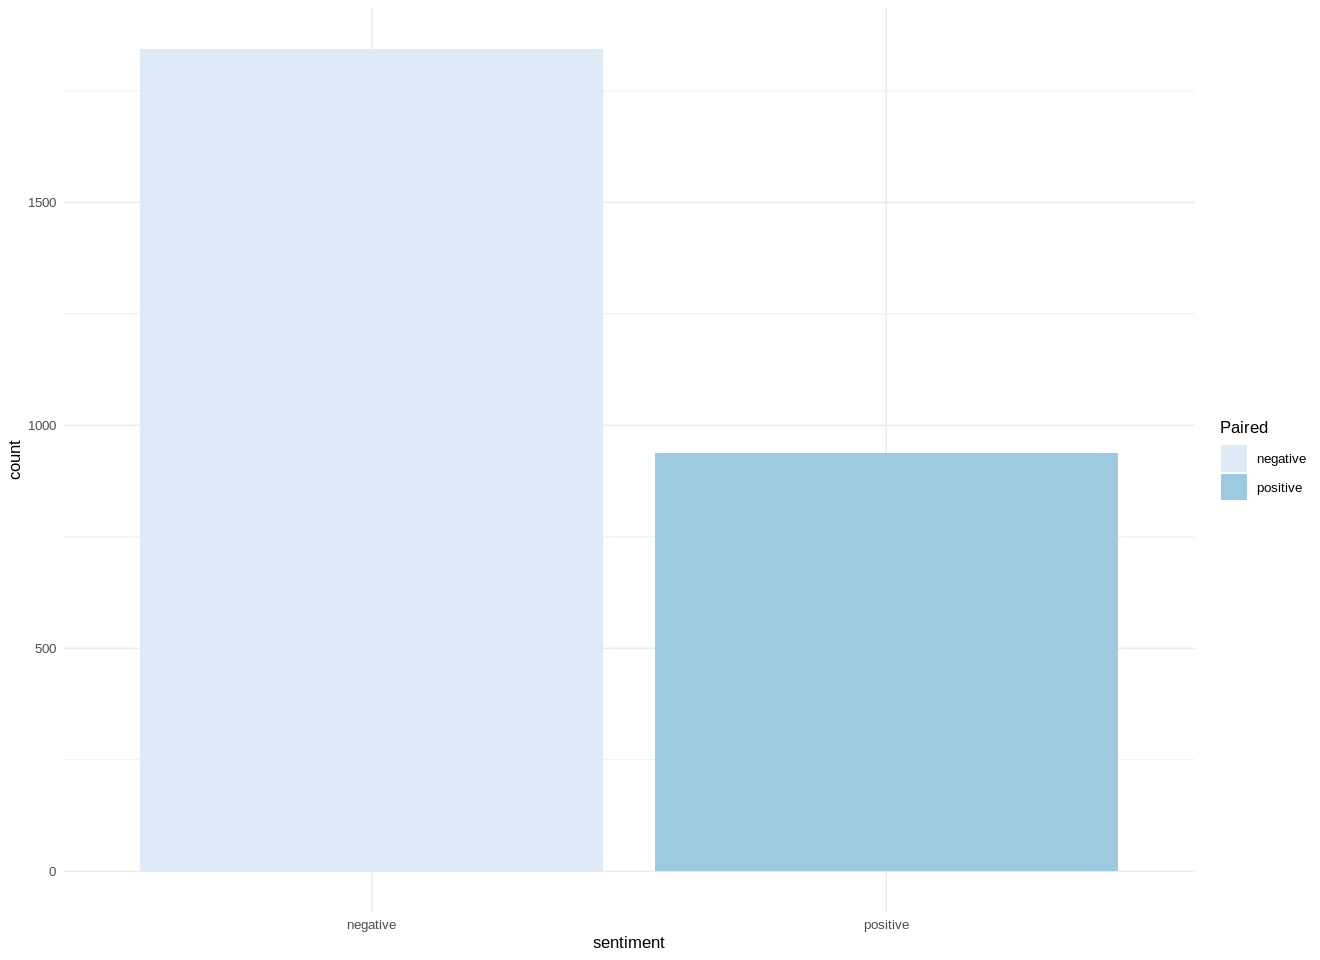

In [13]:
ggplot(dataset, aes(sentiment, fill = sentiment)) + 
  geom_bar() + scale_fill_brewer("Paired")

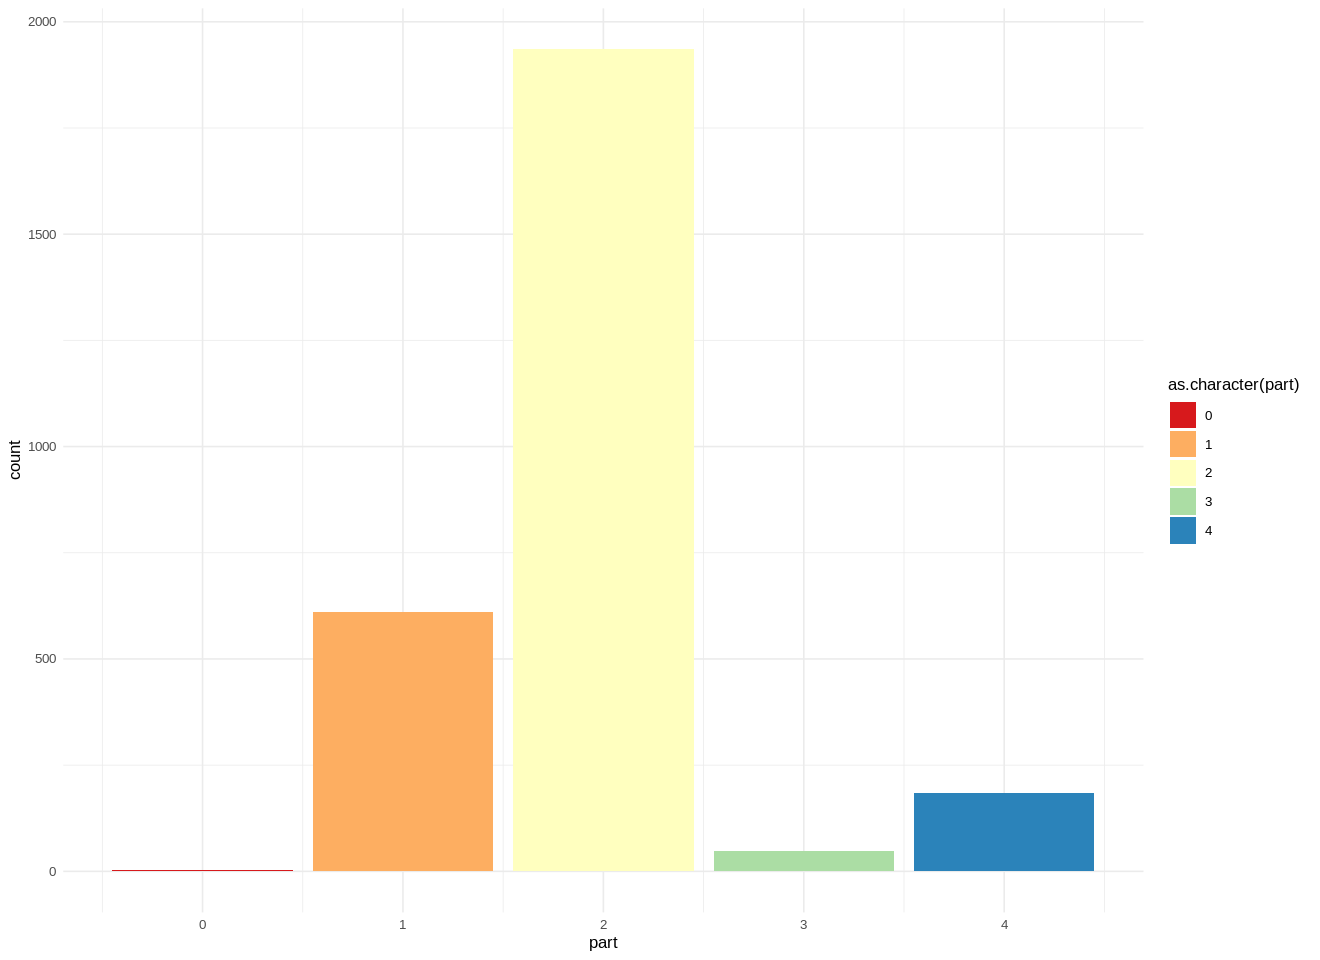

In [89]:
ggplot(dataset, aes(part, fill = as.character(part))) + 
geom_bar() + 
scale_fill_brewer(palette = diverging_palette)

### Prepare data for training

Define target, vector and categorical columns. We have to encode these columns later.

In [15]:
target_col <- c("part")
vector_cols <- colnames(Filter(is.numeric, dataset))
vector_cols <- vector_cols[!vector_cols %in% target_col]
categorical_cols <- colnames(Filter(is.character, dataset))[-c(1)]
feature_cols <- c(vector_cols, categorical_cols)

#### Encode and Data Splitting

Binary encoding for sentiment column where 0 map with `"negative"` and 1 map with `"positive"`. Positions are ordinaly encoded according to their factor values.

In [16]:
dataset.encoded <- dataset %>% 
                  mutate(sentiment = ifelse(sentiment == "negative", 0, 1),
                        pos = as.numeric(factor(pos, levels = unique(pos))))

#### Data Splitting
> Data is splitted accordding to each chapter. Therefor, the data is reproducible and able to prevent underfitting

In [17]:
set.seed(42)

dataset.train <- data.frame()
dataset.val <- data.frame()

dataset.split <- split(dataset.encoded[c(feature_cols, target_col)], dataset.encoded[target_col])

for (chapter in dataset.split) {
  rownames(chapter) <- (1:nrow(chapter))
  train_idx <- sample.int(nrow(chapter) * 0.8)
   
  dataset.train <- rbind(dataset.train, chapter[train_idx, ])
  dataset.val <- rbind(dataset.val, chapter[-train_idx, ])  
}

c(dim(dataset.train), dim(dataset.val))

[1] 2222   33  558   33

#### Label target column
> We'll encode the target labels with one hot encoding

In [18]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’




In [19]:
library(caret)

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity




In [20]:
dataset.train[target_col] <- lapply(dataset.train[target_col], as.character)
dataset.val[target_col] <- lapply(dataset.val[target_col], as.character)

formula <- as.formula(paste0(" ~ ", target_col))
dummy <- dummyVars(formula, data = dataset.train[target_col])

dataset.train <- dataset.train %>% cbind(predict(dummy, dataset.train[target_col])) 
dataset.val <- dataset.val %>% cbind(predict(dummy, dataset.val[target_col])) 

In [21]:
head(dataset.train, 3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V29,V30,sentiment,pos,part,part0,part1,part2,part3,part4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.09205448,-0.3310992,0.4900483,-1.5147220,-0.83553523,0.04334174,0.2274635,0.2760891,0.4476748,-0.1813728,⋯,0.452648843,0.2914995,0,1,0,1,0,0,0,0
485,0.31829369,-0.5231823,-0.3264873,-1.0646289,-0.02908754,0.34069791,0.2533174,0.3293993,-0.6829909,0.3699610,⋯,0.001237156,0.4732374,1,3,1,0,1,0,0,0
321,0.01907839,-0.5059342,0.1682431,0.3995181,0.18066383,0.34332507,0.1432499,-0.1692518,-0.3643060,0.0945259,⋯,0.353830317,-0.3897450,0,5,1,0,1,0,0,0


Shuffle to randomize order of data

In [22]:
set.seed(42)

dataset.train <- dataset.train[sample(nrow(dataset.train)), ]
dataset.val <- dataset.val[sample(nrow(dataset.val)), ]

### Models

#### Deep Neural Network

In [ ]:
install.packages(c("keras", "tensorflow"), quiet = TRUE)
library(keras)
library(tensorflow)

Reshape data for Recurrent Neural Network

In [49]:
target_col <- colnames(dataset.train)[!colnames(dataset.train) %in% c(feature_cols, target_col)]

X_train <- dataset.train[feature_cols]
y_train <- dataset.train[target_col]

X_val <- dataset.val[feature_cols]
y_val <- dataset.val[target_col]

X_train <- array(unlist(X_train), dim = c(nrow(X_train), 1, length(X_train)))
y_train <- matrix(as.matrix(y_train), ncol = ncol(y_train), dimnames = NULL)

X_val <- array(unlist(X_val), dim = c(nrow(X_val), 1, length(X_val)))
y_val <- array(unlist(y_val), dim = c(nrow(X_val), length(y_val)))


c(dim(X_train), dim(y_train))

[1] 2222    1   32 2222    5

In [27]:
input_shape <- dim(X_train)
labels <- target_col

neural_network <- keras_model_sequential() 
neural_network %>%
  bidirectional(layer_lstm(input_shape = input_shape[2:3], units = 128, return_sequences = TRUE)) %>%
  bidirectional(layer_lstm(units = 64, recurrent_dropout = .3)) %>%
  layer_dense(64*input_shape[2], 128, activation = "relu") %>%
  layer_dense(128, activation = "relu") %>%
  layer_dropout(.3) %>%
  layer_dense(length(labels), activation = "softmax")

In [28]:
optimizer <- tf$keras$optimizers$Adam(learning_rate = 3e-5)
loss_fn <- tf$losses$CategoricalCrossentropy(TRUE)
metrics <- c("accuracy", "Precision", "Recall")

neural_network %>% compile(optimizer = optimizer,
                  loss = loss_fn,
                  metrics = metrics
                  )

In [29]:
epochs <- 30
batch_size <- 32

history <- neural_network %>% keras::fit(
  X_train, y_train,
  epochs = epochs,
  batch_size = batch_size,
  validation_data = list(X_val, y_val),
  verbose = 2
)

##### Evaluation

In [30]:
history.df <- data.frame(history$metrics) %>%
              mutate(epochs = (1:epochs)) %>%
              tidyr::pivot_longer(!epochs, names_to = "metric") %>%
              mutate(data = ifelse(grepl("val", metric), "Validation Data", "Trainining Data"),
                    metric = gsub('val_', '', metric))

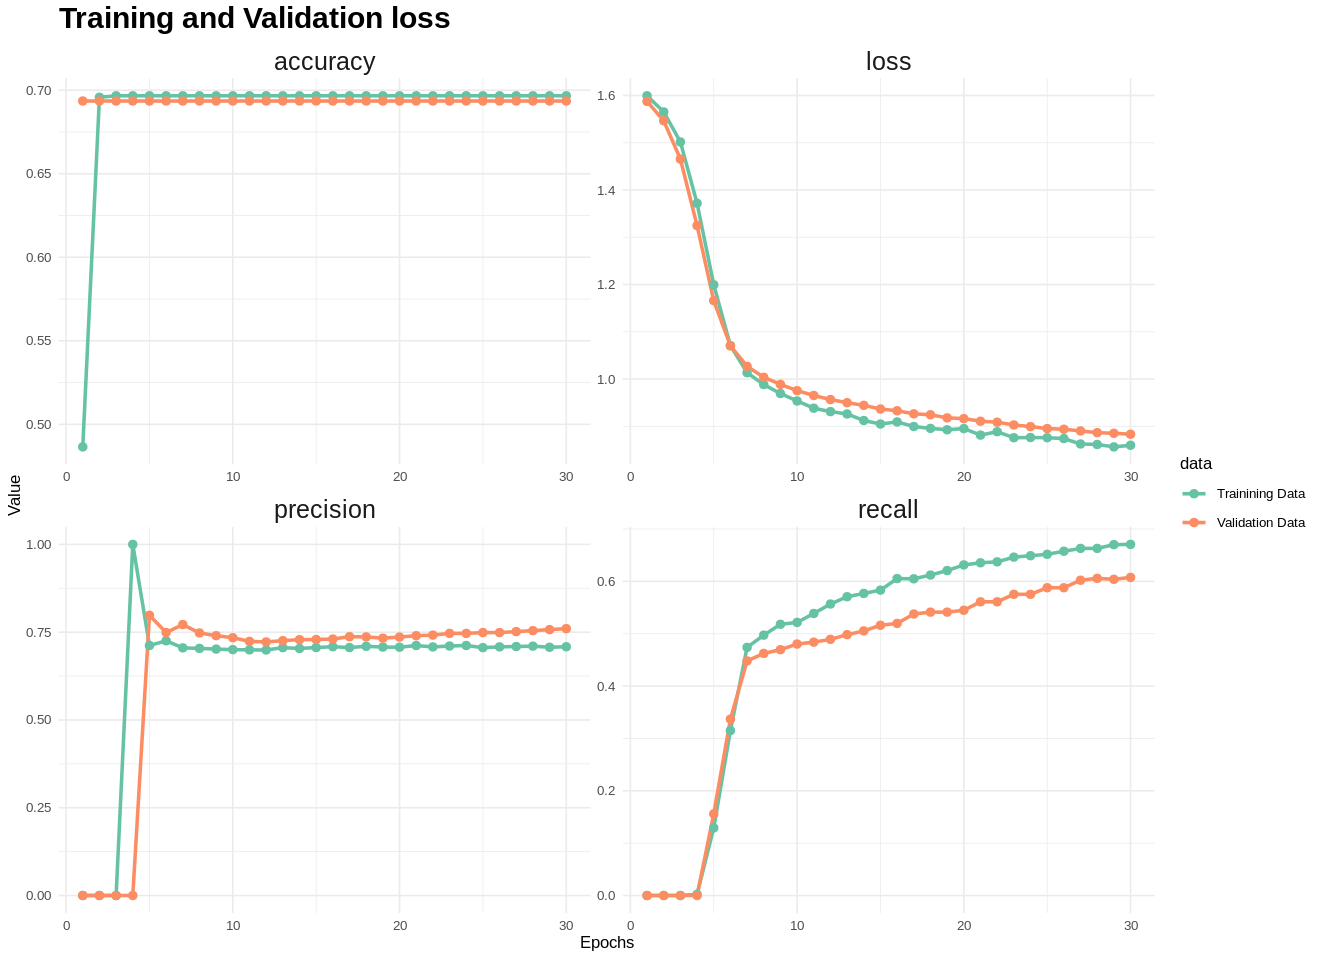

In [31]:
ggplot(history.df, aes(epochs, value, color = data)) + 
  geom_line(size = 1) +
  geom_point(size = 2) +
  scale_color_brewer(palette = "Set2") +
  labs(x = "Epochs", y = "Value", title = paste0("Training and Validation ", history.df$metric)) +
  facet_wrap( ~ metric, ncol =  2, scales = "free") +
  theme(strip.text = element_text(size = 15))

In [ ]:
data.frame(neural_network %>% evaluate(X_train, y_train))

In [68]:
print(neural_network %>% evaluate(X_val, y_val))

     loss  accuracy precision    recall 
0.8833359 0.6935484 0.7600897 0.6075269 


In [56]:
result.nn <- as.data.frame(y_val) %>%
        setNames(labels) %>%
        cbind(neural_network %>% predict(X_val)) %>%
        mutate(pred = apply(data.frame(predict(neural_network, X_val)), 1, function(x) labels[which.max(x)]))
head(result.nn)

,part0,part1,part2,part3,part4,1,2,3,4,5,pred
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,0,1,0,0,0.031623621,0.2585132,0.5379829,0.04927304,0.12260731,part2
2,0,1,0,0,0,0.005509285,0.2427212,0.6772650,0.01195501,0.06254944,part2
3,0,1,0,0,0,0.014626358,0.2531752,0.6135060,0.02652238,0.09217010,part2
4,0,0,1,0,0,0.052418992,0.2764139,0.4516613,0.07500803,0.14449778,part2
5,0,0,1,0,0,0.006432713,0.2192544,0.6953421,0.01335245,0.06561834,part2
6,0,0,1,0,0,0.007461639,0.2554244,0.6495403,0.01535767,0.07221600,part2


#### Random Forest

In [35]:
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [36]:
target_col <- c("part")
classes <- sort(unique(unlist(dataset.train[target_col])))

train <- dataset.train[c(feature_cols, target_col)]
val <- dataset.val[c(feature_cols, target_col)]

train[target_col] <- lapply(train[target_col], as.factor)
val[target_col] <- lapply(val[target_col], as.factor)

In [37]:
formula <- as.formula(paste0(target_col, " ~ ."))
rf <- randomForest::randomForest(formula, data = train, ntree = 500, importance = TRUE)

In [43]:
result.rf <- val[target_col] %>%
          mutate(part = as.factor(part),
          pred = predict(rf, val[feature_cols], type = "response")) %>%
          cbind(predict(rf, val[feature_cols], type = "prob")) 

##### Evaluation Model Performance

 Feature Importance

In [97]:
getPalette(11)

[1] "#D53E4F" "#EA5E46" "#F7874F" "#FDB365" "#FDD682" "#F2EA91" "#DAF09A"
 [8] "#B0DFA2" "#81CCA4" "#56B0AC" "#3288BD"

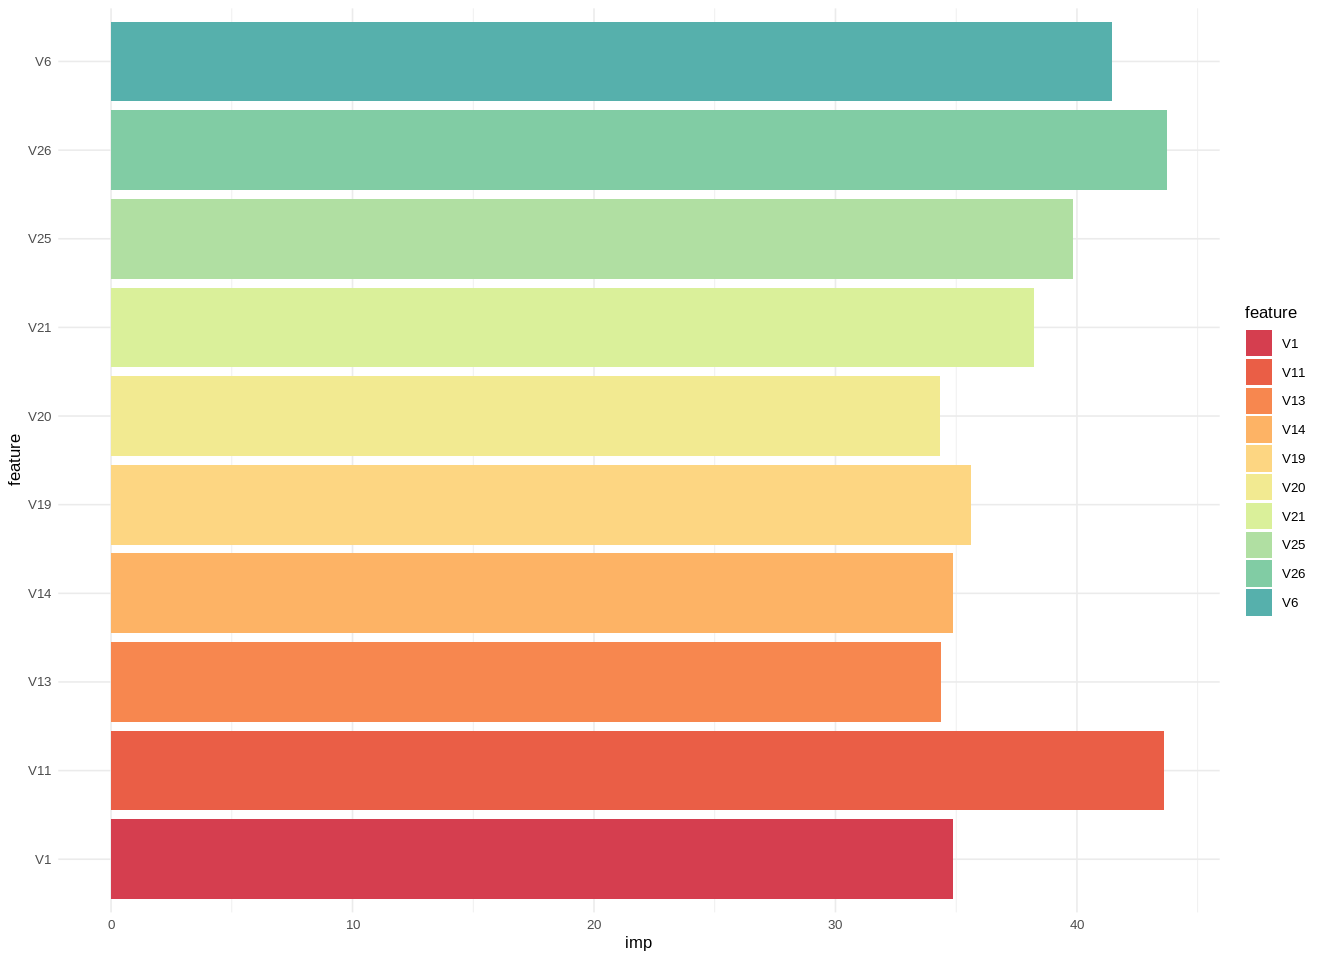

In [100]:
as.data.frame(rf$importance) %>% 
  mutate(feature = row.names(.), imp = MeanDecreaseGini) %>%
  slice_max(imp, n = 10) %>%
  ggplot(aes(imp, feature, fill = feature)) + 
  geom_col() +
  scale_fill_manual(values = getPalette(11))

Confusion Matrix

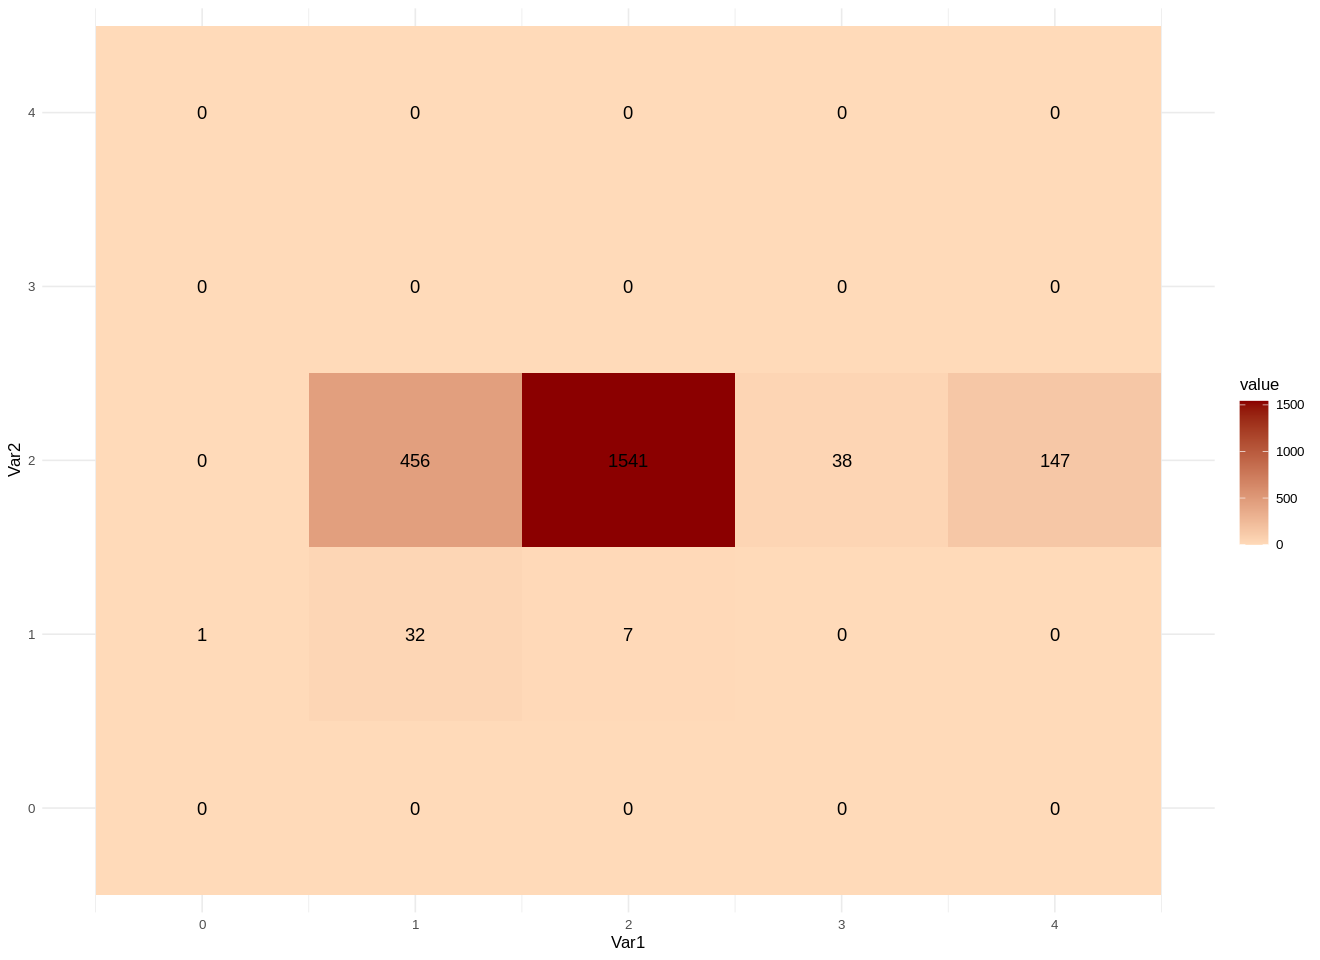

In [41]:
melt(rf$confusion) %>%
filter(Var2 != "class.error") %>%
ggplot(aes(Var1, Var2, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value)) +
  scale_fill_gradient(low = "peachpuff", high = "darkred")

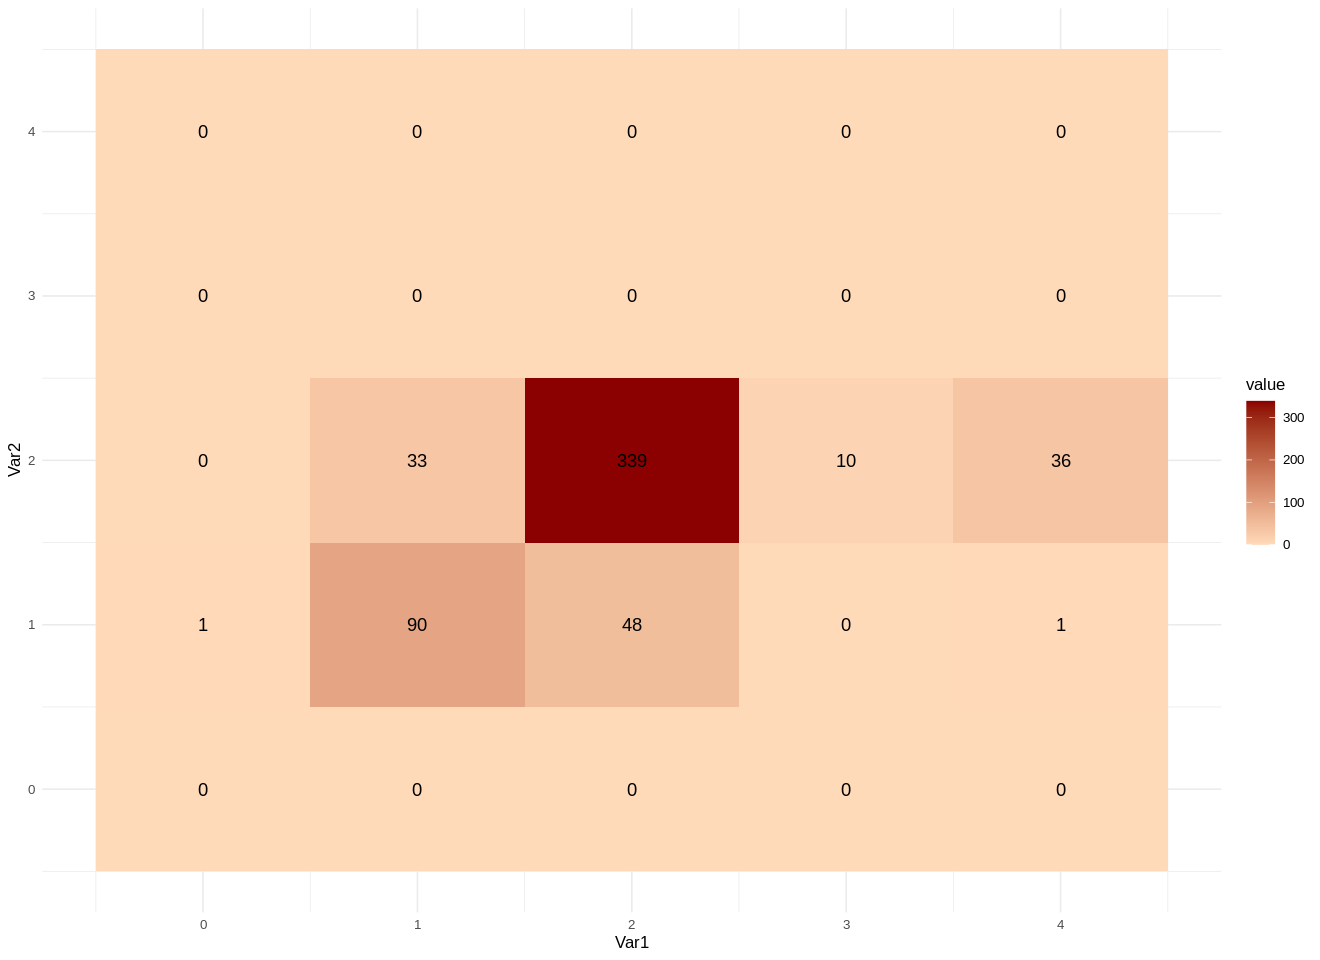

In [47]:
melt(table(unlist(val[target_col]), result.rf$pred)) %>%
ggplot(aes(Var1, Var2, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value)) +
  scale_fill_gradient(low = "peachpuff", high = "darkred")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(classes)` instead of `classes` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



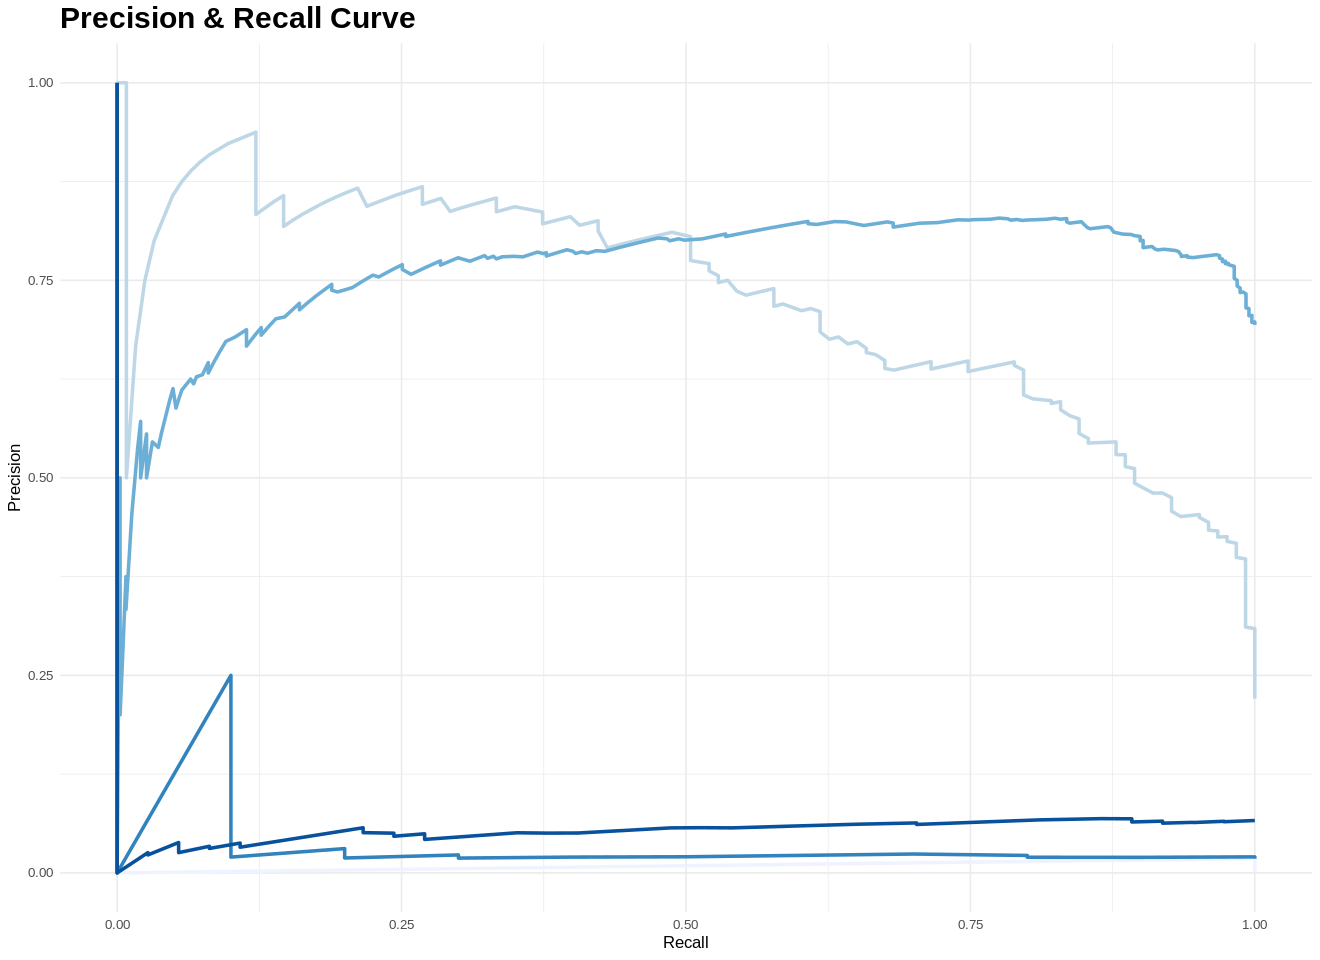

In [48]:
yardstick::pr_curve(result.rf, classes, truth = part) %>%
  ggplot(aes(recall, precision, color = .level)) +
  geom_line(size = 1) +
  scale_color_brewer(discreate_palette, name = "Part") +
  labs(x = "Recall", y = "Precision", title = "Precision & Recall Curve")

Warning message:
“Removed 5 row(s) containing missing values (geom_path).”


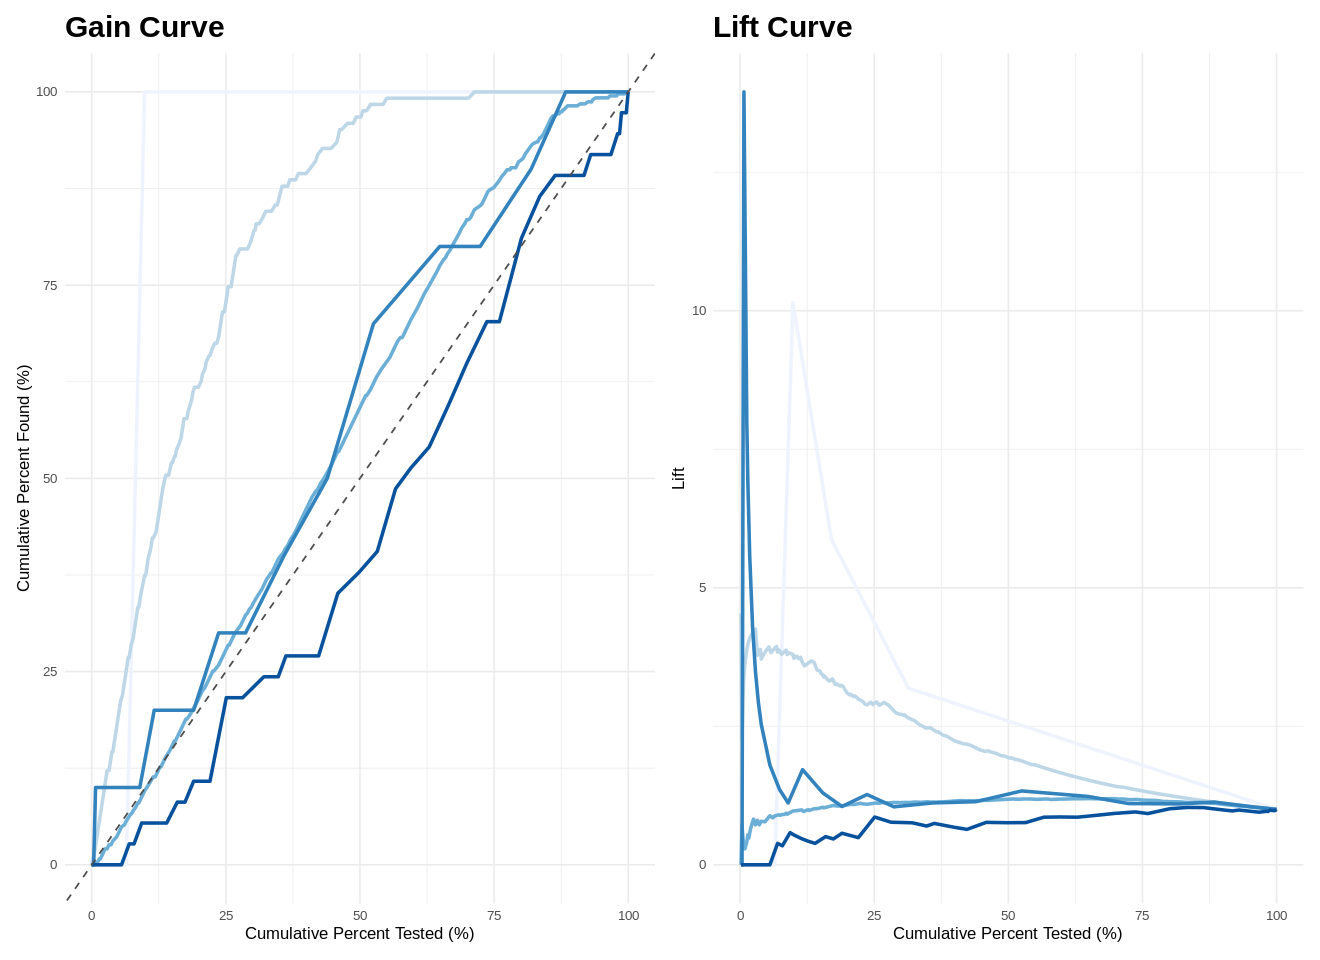

In [83]:
lc <- yardstick::lift_curve(result.rf, all_of(classes), truth = part) %>%
      ggplot(aes(.percent_tested, .lift, color = .level)) +
      geom_line(size = 1) +
      scale_color_brewer(discreate_palette, name = "Part") +
      labs(x = "Cumulative Percent Tested (%)", y = "Lift", title = "Lift Curve")

gc <- yardstick::gain_curve(result.rf, all_of(classes), truth = part) %>%
  ggplot(aes(.percent_tested, .percent_found, color = .level)) +
  geom_line(size = 1) +
  scale_color_brewer(discreate_palette, name = "Part") +
  geom_abline(linetype = "dashed", color = "gray30") +
  labs(x = "Cumulative Percent Tested (%)", y = "Cumulative Percent Found (%)", title = "Gain Curve")

lc + gc 

### References

In [101]:
# https://medium.com/broadhorizon-cmotions/nlp-with-r-part-3-using-topic-model-results-to-predict-michelin-stars-ba8ec1b182c2